# A Neural Probablistic Language Model Implementation

Get the Paper : [A Neural Probablistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

Special Thanks to ANDREJ KARPATHY for the explanation: [Neural Probablistic Language Model Paper Explanation](https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3) 

## Abstract from the Paper

A goal of statistical language modeling is to learn the joint probability function of sequences of words in a language. This is intrinsically difficult because of the curse of dimensionality: a word sequence on which the model will be tested is likely to be different from all the word sequences seen during training. Traditional but very successful approaches based on n-grams obtain generalization by concatenating very short overlapping sequences seen in the training set. We propose to fight the curse of dimensionality by learning a distributed representation for words which allows each training sentence to inform the model about an exponential number of semantically neighboring sentences. The model learns simultaneously (1) a distributed representation for each word along with (2) the probability function for word sequences, expressed in terms of these representations. 
Generalization is obtained because a sequence of words that has never been seen before gets high probability if it is made of words that are similar (in the sense of having a nearby representation) to words forming an already seen sentence. Training such large models (with millions of parameters) within a reasonable time is itself a significant challenge. We report on experiments using neural networks for the probability function, showing on two text corpora that the proposed approach significantly improves on state-of-the-art n-gram models, and that the proposed approach allows to take advantage of longer contexts.


A statistical model of language can be represented by the conditional probability of the next
word given all the previous ones, since

$$\begin{align*} \\ 
\hat{P}(w_1^T) = \prod_{t=1}^{T} \hat{P}(w_t \mid w_1^{t-1}) \tag{1} \\
\end{align*}$$

Simple Explanation of each term on the probability Equation from Mathetical Perpective:
1.	Sequence Notation:  $w_1^T$  denotes a sequence of elements from  $w_1$  to  $w_T$ . This could represent a sequence of words in a sentence, for example.
2.	Conditional Probability: $\hat{P}(w_t \mid w_1^{t-1})$  is the predicted probability of the  $t^{th}$ element in the sequence, given all the previous elements in the sequence from $w_1$  to  $w_{t-1}$ .
3.	Product of Probabilities: The product notation  $\prod_{t=1}^{T}$ indicates that we are multiplying the conditional probabilities of each element in the sequence. This multiplication is performed from  $t = 1$  to  $t = T$ .

In the Equation $(1), \;\;\; w_t$ is the $t^{th}$ word, and writing sub-sequence $w^{j}_{i}$ = $(w_{i}, w_{i+1},···, w_{j−1}, w_{j})$. Such statistical language models have already been found useful in many technological applications involving natural language, such as speech recognition, language translation, and information retrieval.




When building statistical models of natural language, one considerably reduces the difficulty of this modeling problem by taking advantage of word order, and the fact that temporally closer words in the word sequence are statistically more dependent. Thus, n-gram models construct tables of conditional probabilities for the next word, for each one of a large number of contexts, i.e. combinations of the last n−1 words:

$$\begin{align*} 
\hat{P}(w_t | w_{1}^{t-1}) \approx \hat{P}(w_t \mid w_{t-n+1}^{t-1}) 
\end{align*}$$


In case of this implementation the learning set is reduced from words to letters. Instead of generating sentences using probabilistic approach, this model will be generating names from a dataset of names.

[Dataset Source Link](https://github.com/karpathy/makemore/blob/master/names.txt)

## Fighting the Curse of Dimensionality with Distributed Representations

In [129]:
# Fetching the dataset and putting in the data dir
!mkdir -p ./data/names_dataset
!curl -o ./data/names_dataset/names.txt https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  222k  100  222k    0     0   214k      0  0:00:01  0:00:01 --:--:--  214k



In our current project, we are focused on building a character-level language model. However, the paper we are examining employs a word-level language model with a vocabulary of 17,000 possible words. In this paper, each word is associated with a 30-dimensional feature vector, embedding every word into a 30-dimensional space. Initially, these word embeddings are randomly distributed within the space. During the training process, backpropagation is used to tune these embeddings, causing the word vectors to move. Words with similar meanings or synonyms are likely to cluster together in similar regions of the space, while words with different meanings will be more dispersed. The paper's modeling approach is otherwise identical to ours, utilizing a multi-layer neural network to predict the next word based on previous words and maximizing the log likelihood of the training data. To illustrate this approach, the paper provides a concrete example demonstrating their intuition.

### Explanation
If we understand that certain objects, such as "dog" and "cat," share similar roles both semantically and syntactically, and the same applies to pairs like "the" and "a," "bedroom" and "room," and "is" and "was," we can naturally extend (or transfer probability mass) from the sentence "The cat is walking in the bedroom" to "A dog was running in a room." Similarly, this allows us to generalize to sentences like "The cat is running in a room," "A dog is walking in a bedroom," and "The dog was walking in the room."

In [130]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt

%matplotlib inline

In [131]:
# Reading the file
words = open("./data/names_dataset/names.txt", 'r').read().splitlines()
words[:5], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia'], 32033)

In [132]:
## Building a dictionary mapping of each letter to a number
# chars = sorted()
chars =sorted(list(set(''.join(words)))) # Take all the words in the words(list) and join them to make a string, create a set of words(sets are unordered but each element is unique), convert that to a list and sort it.
stoi = {s:i+1 for i,s in enumerate(chars)} # buiding the dictionary from the chars 
stoi['.'] = 0


itos = {i:s for s,i in stoi.items()} # Just making another list that maps intergers -> char/string


In [260]:
import random

block_size = 3  ## This is the context window. Number of characters we take to predict the next one.

# Building the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)  # X appends a context list. Results in a 2d list
            Y.append(ix)  # Y just appends the representation based on the context
            # print(''.join(itos[ch] for ch in context), " ---> " , itos[ix]) # debuging statement
            context = (
                context[1:] + [ix]
            )  # Remove the first element from the list and add the new character(integer representation value)
    
    # Convert the X and Y in the torch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

random.seed(42)
random.shuffle(words) ## Randomly shuffling the words
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words=words[:n1])
Xval, Yval = build_dataset(words=words[n1:n2])
Xtest, Ytest = build_dataset(words=words[:n2])

(Xtr.shape, Xval.shape, Xtest.shape), (Ytr.shape, Yval.shape, Ytest.shape)

((torch.Size([182424, 3]), torch.Size([22836, 3]), torch.Size([205260, 3])),
 (torch.Size([182424]), torch.Size([22836]), torch.Size([205260])))

In [ ]:
X,Y = build_dataset(words=words)

## Architecture of the Model


### Training Set and Objective
- The training set is a sequence $ w_1 \cdots w_T $ of ~~words~~ letters $ w_t \in V $, where the vocabulary $ V $ is a large but finite set.
- The objective is to learn a good model $ f(w_t, \cdots, w_{t+n}) = \hat{P}(w_t | w_{t-1}^1) $, which gives a high out-of-sample likelihood.
- Perplexity is used as a measure, being the exponential of the average negative log-likelihood.
- The constraint on the model is that for any choice of $ w_{t-1}^1 $, the product of these conditional probabilities provides a model of the joint probability of sequences of ~~words~~ letters.

### Function Decomposition
- The function $ f(w_t, \cdots, w_{t+n}) = \hat{P}(w_t | w_{t-1}^1) $ is decomposed into two parts:
  1. **Mapping C**: Maps any element $ i $ of $ V $ to a real vector $ C(i) \in \mathbb{R}^m $. It represents the distributed feature vectors associated with each word in the vocabulary. Practically, $ C $ is represented by a $ |V| \times m $ matrix of free parameters.
  2. **Probability Function**: Uses $ C $. A function $ g $ maps an input sequence of feature vectors for ~~words~~ letters in context to a conditional probability distribution over ~~words~~ letters in $ V $ for the next word $ w_t $. The output of $ g $ is a vector where the $ i $-th element estimates the probability $ \hat{P}(w_t = i | w_{t-1}^1) $.

$$
f(i, w_{t-1}^1, \cdots, w_{t+n-1}) = g_i(C(w_{t-n+1}), \cdots, C(w_{t-1}))
$$

- The function $ f $ is a composition of these two mappings ($ C $ and $ g $), with $ C $ being shared across all ~~words~~letters in the context.
- Each part has associated parameters.


![Neural architecture For the Model](<./img/Neural Probabilistic Language Model/Screenshot 2024-06-24 at 4.15.21 PM.jpg>)

We are implementing an embedding lookup table for our model. With 27 possible characters, we will embed them into a lower-dimensional space. In the referenced paper, they managed to embed 17,000 words into a 30-dimensional space, demonstrating the ability to compress a large vocabulary into a small-dimensional space. For our purposes, we will begin by embedding our 27 characters into a similarly small-dimensional space.



In [135]:
# Implementing C in the diagram
C = torch.randn((27, 2))  # C is initialized with random values


In [136]:
t = [[1,2,3,4],
     [3,4,5,6],
     [5,6,7,8]] # 3*4 

temp = C[torch.tensor(t)]
temp.shape


torch.Size([3, 4, 2])

In [137]:
emb = C[X]  # Dont really understand the underlying reason for doing this but I get what it does
emb.shape  ## This should be X.shape[0], X.shape[1], C.shape[1]


torch.Size([228146, 3, 2])

In [138]:
# Constructing the hidden layer
W1 = torch.randn(6,100) # 6 comes from emb.shape[1] * emb.shape[2]
b1 = torch.randn(100)
W1.shape , W1.dtype, b1.shape, b1.dtype

(torch.Size([6, 100]), torch.float32, torch.Size([100]), torch.float32)

In [139]:
# Now what we want to do is emb . W1 + b1
# Problem that is emb is ([228146, 3, 2]) and W1 is [6,100]. SO we need ot change the view for the emb
if len(emb.shape) == 3:
    New_emb = emb.view( emb.shape[0], emb.shape[1] * emb.shape[2]  )
else:
    print("Emb is already a 2d array ")




### Understand How View works in Pytorch and why is it efficient ? 
Read This arcticle: [Blog By Ezyang on Pytorch Internals](http://blog.ezyang.com/2019/05/pytorch-internals/)

In [140]:
# DO not run this operation the upper block, the values of 
New_emb.shape

torch.Size([228146, 6])

In [141]:
# Andrej Karpathy Method of doing the same
# The view is a better way but he showed this method initially.
# Both yielded the same results, 
# TODO: Investigate the working of this code.
temp_emb = torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)

temp_emb.shape

torch.Size([228146, 6])

In [142]:
# Check if they are equal
# Just verifying the math.
are_equal = torch.equal(New_emb, temp_emb)
print("Are the tensors equal? ", are_equal)

Are the tensors equal?  True


In [143]:
# We can now perform the emb . W1 + b1
tanh = torch.tanh(New_emb @ W1 + b1) # Performing the non-linearity function as I calculate the values.
tanh.shape


torch.Size([228146, 100])

In [144]:
# Implementing the final layer
W2 = torch.randn((100, 27)) # 27 because we have 27 possible characters 

# performing some math:  tanh @ W2 = [tanh.shape[0], 100]
b2  = torch.randn(27)
W2.shape, b2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [145]:
logits = tanh @ W2 + b2
logits.shape

torch.Size([228146, 27])

# Implementing Softmax Activation Function
$$
\sigma(z)i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}
$$

Here,  $z$  represents the input vector (logits),  $\sigma(z)_i$  is the softmax output for the  $i^{th}$ class, and  $K$  is the number of classes.


In [146]:
## Do not do this in practise. Pytorch will not create all the intermediary tensors to calculate the loss, and using cross entropy is the best practical solution.
# Using cross Entropy pytorch function will make it efficient to calc back prop 
# Cross ENtropy is the mathematically well behaved, CS231n gets into it, HINT exp can lead to counts values exploding the getting NaN
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs.shape
loss = -probs[torch.arange(Y.shape[0]), Y].log().mean()
loss 

tensor(14.8788)

## -------------------------------- Putting it all together into a model --------------------------------

In [238]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10))  # C is initialized with random values
W1 = torch.randn(30, 200)  # 6 comes from emb.shape[1] * emb.shape[2]
b1 = torch.randn(200)
W2 = torch.randn((200, 27))  # 27 because we have 27 possible characters
b2 = torch.randn(27)  
parameters = [C,W1,b1,W2,b2]


In [239]:
sum(p.nelement() for p in parameters)

11897

In [240]:
for p in parameters:
    p.requires_grad = True
    

In [241]:

# Setting up the learning. A reasonable learning rate is somewhere between -0.001 and -1
lre = torch.linspace(start = -3, end = 0, steps = 1000 ) 
lrs = 10**lre

In [242]:
# Keep Track of the learning rate used and the losses
lri = []
lossi = []
stepi = []
lr = 10**-2


In [255]:
# Putting it all
# Forwards pass
for epoch in range(200000):
    # Implementing Mini Batch
    mb = torch.randint(0, Xtr.shape[0], (32,))  # 32 is the batch size.

    # emb = C[X]  # X.shape[0], X.shape[1], C.shape[1]
    emb = C[Xtr[mb]]  # 32 , X.shape[1], C.shape[1] that is torch.Size([32, 3, 10])

    # Tanh activation function
    h = torch.tanh(
        emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1
    )  # Give out X.shape[0], 100, with Mini batch this is now shaped 32, 100

    logits = h @ W2 + b2  # Gives out (X.shape , 27)
    loss = F.cross_entropy(logits, Ytr[mb])
    # print(f"Epoch: {epoch+1}, loss: {loss.item() :.3f}")

    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 10**-1 if epoch < 100000 else 10**-2
    for p in parameters:
        p.data += -lr * p.grad

    #    tracking stats
    # lri.append(lre[epoch])
    stepi.append(epoch)
    lossi.append(loss.log10().item())

print(f" RESULTING LOSS: {loss.item() :.3f}%")


 RESULTING LOSS: 1.673%


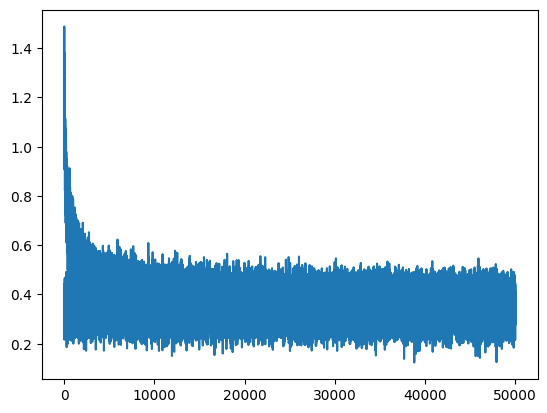

In [253]:
plt.plot(stepi, lossi)

# Determing the learing Rate
We can we that the learning rate is the good at 0.75 to 0.125-ish. As the learning rate gets bigger than, things start to explode. The learning rate from trail and error method is set to $10^{-1}$ or $0.1$

In [258]:
## Evaluating the model on the validation set
emb = C[Xval]
tanh = torch.tanh(emb.view(emb.shape[0], emb.shape[1] * emb.shape[2])  @ W1 + b1 )
logits = tanh @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss.item()

2.1268277168273926

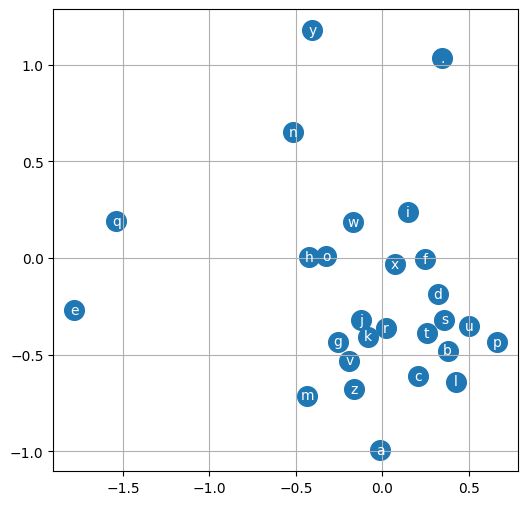

In [251]:
plt.figure(figsize=(6, 6))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

In [262]:
## Sampling from the model
g = torch.Generator().manual_seed(2147483647 - 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

nas.
bent.
makeyn.
olattathi.
lesegh.
nao.
marchano.
keyleey.
jami.
miyah.
peizlyn.
kaylenoamiron.
gion.
ella.
arid.
lin.
sreamerrisha.
shaela.
pasiyanett.
rivornoriellena.
